## Introduction: What is portfolio optimization?
Portfolio optimization is a crucial process for anyone who wants to maximize returns from their investments. 
Investments are usually a collection of so-called assets (stock, credits, bonds, derivatives, calls, puts, etc..) and this collection of assets is called a **portfolio**. 
<center><img src="ex1-01.png" width="270"></center>
The goal of portfolio optimization is to minimize risks (financial loss) and maximize returns (financial gain). But this process is not as simple as it may seem. Gaining high returns with little risk is indeed too good to be true. Risks and returns usually have a trade-off relationship which makes optmizing your portfolio a little more complicated. As Dr. Harry Markowitz states in his Moderbn Portfolio Theory he created in 1952,  "risk is an inherrent part of higher reward."

## Stock Portfolio Optimization Problem

Let us consider a portfolio optimization problem where you have a total of four assets (e.g. STOCK0, STOCK1, STOCK2, STOCK3) to choose from. Your goal is to find out a combination of two assets that will minimize the tradeoff between risk and return which is the same as finding the efficient frontier for the given risk. 

## Import Library

In [44]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from qiskit import IBMQ, QuantumCircuit
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import *
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer 
from qiskit_optimization.algorithms.optimization_algorithm import OptimizationResult
from time import time
from getpass import getpass
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer

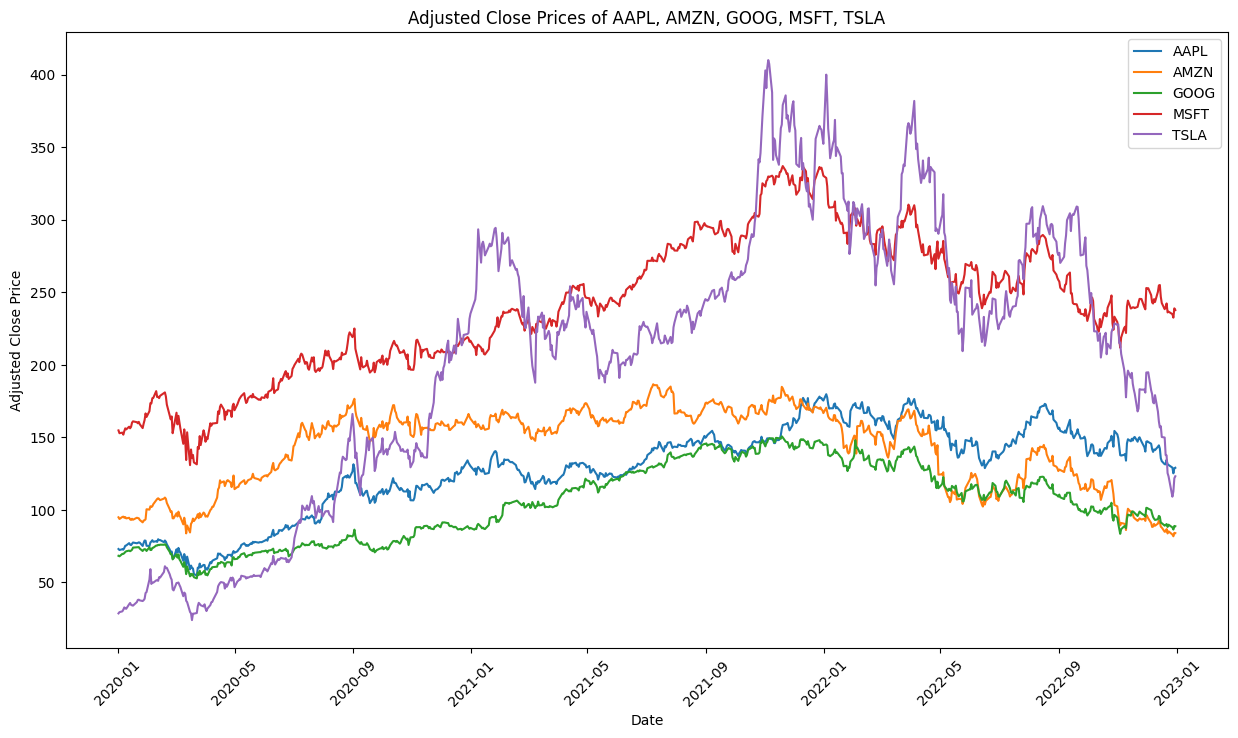

In [45]:
# Load the data from the file
file_path = 'data/stocks_data.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Remove non-data rows (such as headers and metadata in this dataset)
data_cleaned = data.drop([0, 1])  # Drop the first two rows

# Assuming the date information is in the first column after the dropped rows
data_cleaned['Date'] = pd.to_datetime(data_cleaned.iloc[:, 0])
data_cleaned.set_index('Date', inplace=True)

# Select only the columns for Adjusted Close Prices
adj_close_columns = [col for col in data_cleaned.columns if 'Adj Close' in col]
adj_close_data = data_cleaned[adj_close_columns]

# Rename columns for clarity
adj_close_data.columns = ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'TSLA']

# Convert the data to numeric type for analysis
adj_close_data = adj_close_data.apply(pd.to_numeric)

# Plotting each stock's Adjusted Close Price
plt.figure(figsize=(15, 8))

for column in adj_close_data.columns:
    plt.plot(adj_close_data.index, adj_close_data[column], label=column)

plt.title('Adjusted Close Prices of AAPL, AMZN, GOOG, MSFT, TSLA')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend()
plt.show()

In [46]:
# Calculate daily returns
daily_returns = adj_close_data.pct_change().dropna()

# Calculate mean return
mean_returns = daily_returns.mean()

# Calculate covariance matrix of returns
covariance_matrix = daily_returns.cov()

mean_returns, covariance_matrix

(AAPL    0.001024
 AMZN    0.000141
 GOOG    0.000580
 MSFT    0.000808
 TSLA    0.002965
 dtype: float64,
           AAPL      AMZN      GOOG      MSFT      TSLA
 AAPL  0.000541  0.000380  0.000367  0.000413  0.000550
 AMZN  0.000380  0.000606  0.000364  0.000378  0.000534
 GOOG  0.000367  0.000364  0.000469  0.000391  0.000446
 MSFT  0.000413  0.000378  0.000391  0.000479  0.000499
 TSLA  0.000550  0.000534  0.000446  0.000499  0.002068)

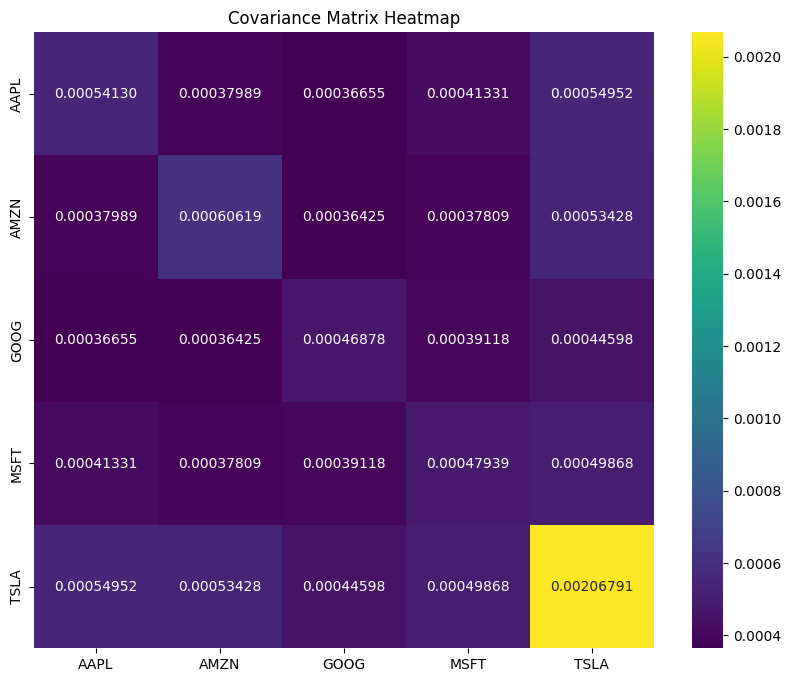

In [47]:
import seaborn as sns
# Plotting the covariance matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(covariance_matrix, annot=True, fmt='.8f', cmap='viridis')

plt.title('Covariance Matrix Heatmap')

plt.show()

In [48]:
# Calculate mean returns (mu) and covariance matrix as annual performance of a portfolio based on daily returns data
mean_returns = mean_returns *252  # Annualize the mean returns
covariance_matrix = covariance_matrix * 252  # Annualize the covariance matrix

# # Print results
print("Annualized Mean Returns (mu):")
print(mean_returns)

print("\nAnnualized Covariance Matrix:")
print(covariance_matrix)

Annualized Mean Returns (mu):
AAPL    0.258011
AMZN    0.035559
GOOG    0.146087
MSFT    0.203655
TSLA    0.747064
dtype: float64

Annualized Covariance Matrix:
          AAPL      AMZN      GOOG      MSFT      TSLA
AAPL  0.136407  0.095733  0.092371  0.104155  0.138480
AMZN  0.095733  0.152759  0.091791  0.095278  0.134639
GOOG  0.092371  0.091791  0.118134  0.098577  0.112386
MSFT  0.104155  0.095278  0.098577  0.120806  0.125667
TSLA  0.138480  0.134639  0.112386  0.125667  0.521113


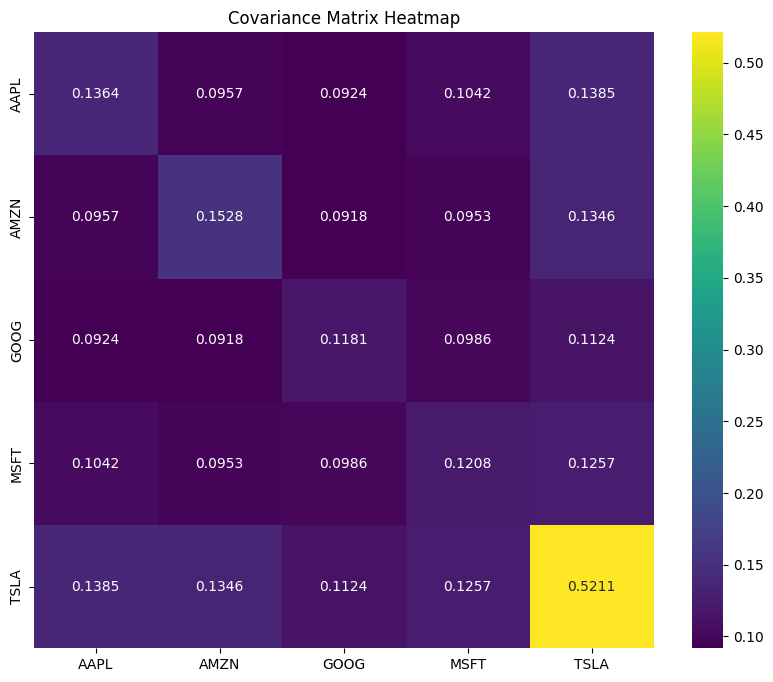

In [49]:
plt.figure(figsize=(10, 8))
sns.heatmap(covariance_matrix, annot=True, fmt='.4f', cmap='viridis')
plt.title('Covariance Matrix Heatmap')
plt.show()

In [50]:
print("Length of mean_returns:", len(mean_returns))
print("Shape of covariance_matrix:", covariance_matrix.shape)

Length of mean_returns: 5
Shape of covariance_matrix: (5, 5)


In [87]:
num_assets = 5
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
# penalty = num_assets  # set parameter to scale the budget penalty term

# Convert to numpy array if mean_returns is a pandas Series and covariance_matrix is a pandas DataFrame
expected_returns = mean_returns.values
covariances = covariance_matrix.values

portfolio = PortfolioOptimization(
    expected_returns=expected_returns,
    covariances=covariances,
    risk_factor=q,
    budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.06820359132622808*x_0^2 + 0.09573300437764926*x_..., 5 variables, 1 constraints, 'Portfolio optimization'>

### Utility Method 

In [88]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

## Solving the problem classically using NumPyMinimumEigensolver for reference 


In [90]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 0. 1.], value -0.5378

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 0 0 1]	-0.5378		1.0000


## Solution using `SamplingVQE`
We can now use the Sampling Variational Quantum Eigensolver (`SamplingVQE`) to solve the problem. We will specify the optimizer and variational form to be used.

In [85]:
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes)
result = svqe.solve(qp)

print_result(result)

Optimal: selection [1. 1. 1. 1. 1.], value 0.2233

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 0 1 1]	-0.0848		0.5029
[1 1 1 1 1]	0.2233		0.1650
[0 0 1 1 1]	-0.3801		0.0947
[1 0 1 1 1]	-0.2350		0.0566
[0 1 0 1 1]	-0.2334		0.0459
[1 0 0 1 1]	-0.4513		0.0342
[0 1 1 0 1]	-0.1939		0.0283
[0 0 1 0 1]	-0.4611		0.0137
[1 0 1 0 1]	-0.4201		0.0107
[1 1 1 1 0]	0.1986		0.0078
[0 1 1 1 1]	-0.0176		0.0059
[1 1 0 0 1]	-0.2666		0.0059
[1 0 1 1 0]	-0.1250		0.0049
[0 1 0 1 0]	-0.0072		0.0049
[0 0 0 0 0]	0.0000		0.0029
[0 1 0 0 1]	-0.3110		0.0029
[1 1 1 0 0]	0.0439		0.0029
[0 0 1 1 0]	-0.1317		0.0020
[1 1 0 1 0]	0.0029		0.0020
[1 1 1 0 1]	-0.0571		0.0020
[1 0 1 0 0]	-0.1845		0.0020
[0 0 0 1 1]	-0.5041		0.0010
[1 0 0 0 1]	-0.5378		0.0010


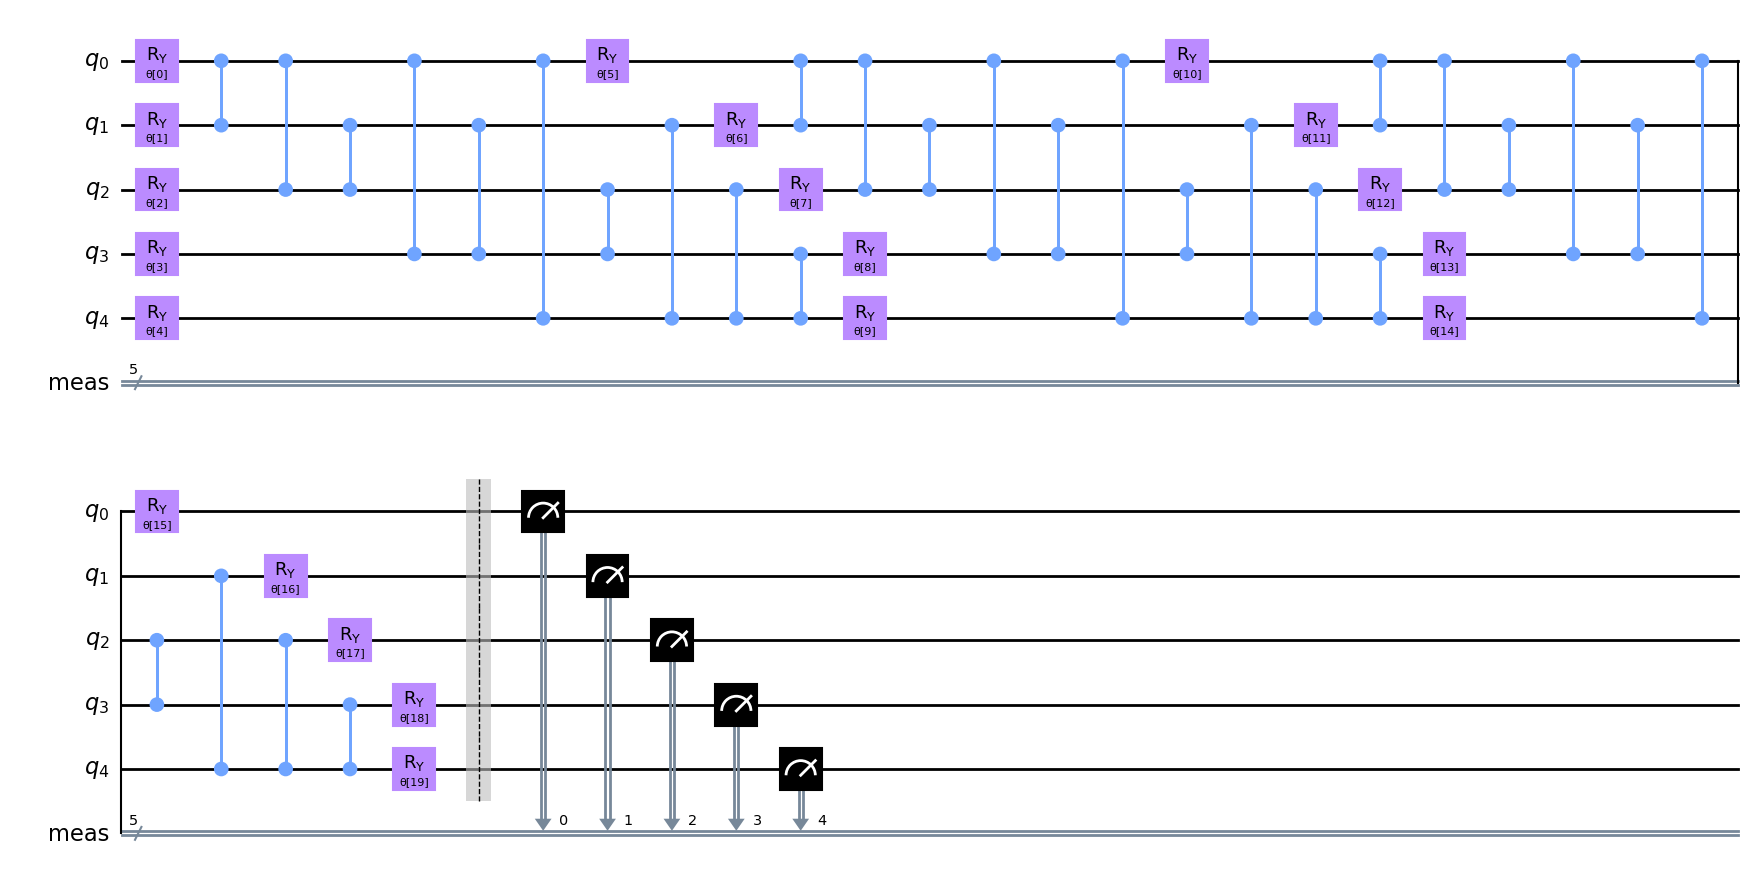

In [86]:
ry.decompose().draw("mpl") #Displaying the Ansatz circuit


### Solution using `QAOA`

We also show here a result using the Quantum Approximate Optimization Algorithm (`QAOA`). This is another variational algorithm and it uses an internal variational form that is created based on the problem.

In [80]:
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 1. 1. 1.], value -0.2350

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 1 1 0]	0.1986		0.2021
[1 0 1 1 0]	-0.1250		0.1963
[0 1 1 1 0]	0.0962		0.1699
[1 1 1 0 0]	0.0439		0.1123
[1 1 0 1 0]	0.0029		0.1084
[0 0 1 1 0]	-0.1317		0.0215
[1 0 1 0 0]	-0.1845		0.0137
[0 1 1 0 0]	0.0456		0.0137
[1 0 0 1 0]	-0.2289		0.0137
[0 0 0 0 0]	0.0000		0.0127
[1 1 1 0 1]	-0.0571		0.0127
[0 1 0 0 1]	-0.3110		0.0107
[1 1 0 1 1]	-0.0848		0.0107
[0 0 1 1 1]	-0.3801		0.0107
[0 1 1 1 1]	-0.0176		0.0098
[1 0 1 1 1]	-0.2350		0.0098
[0 1 1 0 1]	-0.1939		0.0078
[1 0 0 1 1]	-0.4513		0.0078
[0 1 0 1 0]	-0.0072		0.0078
[1 0 1 0 1]	-0.4201		0.0068
[0 1 0 1 1]	-0.2334		0.0059
[0 1 0 0 0]	0.0408		0.0059
[1 1 1 1 1]	0.2233		0.0049
[0 0 0 1 0]	-0.1433		0.0039
[1 0 0 0 0]	-0.1898		0.0039
[0 0 1 0 0]	-0.0870		0.0039
[0 0 0 0 1]	-0.4865		0.0039
[1 1 0 0 1]	-0.2666		0.0039
[0 0 1 0 1]	-0.4611		0.0029
[1 0 0 0 1]